In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import keras
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils.np_utils import to_categorical
from scipy import ndimage

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

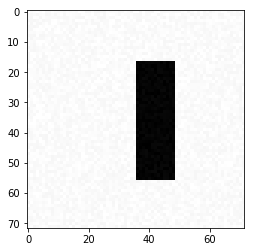

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

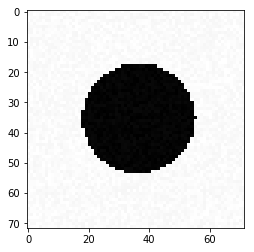

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

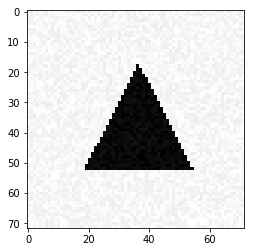

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# Question 3 #

In [6]:
# Creation of the training dataset, with fixed center and dimensions (I disabled progress logging in the creation)
[X_train, Y_train] = generate_dataset_classification(300, 20)
print("Training dataset created")

# Encode labels into one-hot vectors
Y_train_categorical = np.array(list(map(int, Y_train)))
Y_train_categorical = to_categorical(Y_train_categorical, num_classes=3)

Creating data:
Training dataset created


In [7]:
# Define, compile and train linear models (for 30 epochs) with either SGD or Adam as optimizers
optims = [optimizers.SGD(lr=0.001, decay=0.0, momentum=0.9, nesterov=True), optimizers.Adam(lr=0.001)]
models = []

for optim in optims:
    
    # Define model
    reg_coeff = 0 # L2 regularization coefficient
    model = Sequential([
        Dense(3, input_shape=(5184, ), kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('softmax'),
    ])
    
    # Compile model
    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train, Y_train_categorical, epochs=30, batch_size=32)
    
    # Add model to the model list
    models.append(model)

Epoch 1/30
300/300 [==============================] - 0s 817us/step - loss: 1.1826 - acc: 0.5100
Epoch 2/30
300/300 [==============================] - 0s 160us/step - loss: 0.7513 - acc: 0.6500
Epoch 3/30
300/300 [==============================] - 0s 153us/step - loss: 0.4785 - acc: 0.8300
Epoch 4/30
300/300 [==============================] - 0s 143us/step - loss: 0.3993 - acc: 0.8467
Epoch 5/30
300/300 [==============================] - 0s 147us/step - loss: 0.3500 - acc: 0.8967
Epoch 6/30
300/300 [==============================] - 0s 147us/step - loss: 0.2718 - acc: 0.9600
Epoch 7/30
300/300 [==============================] - 0s 147us/step - loss: 0.2846 - acc: 0.8933
Epoch 8/30
300/300 [==============================] - 0s 143us/step - loss: 0.2403 - acc: 0.9267
Epoch 9/30
300/300 [==============================] - 0s 137us/step - loss: 0.2277 - acc: 0.9300
Epoch 10/30
300/300 [==============================] - 0s 140us/step - loss: 0.2183 - acc: 0.9333
Epoch 11/30
300/300 [========

In [8]:
# I modified the signature of generate_test_set_classification so that
# I can choose to fix the centers and dimensions or not (fixed by default)

# Generation of the test dataset
[X_test, Y_test] = generate_test_set_classification()
print("Test dataset created")

# Labels proportions
proportions = [0, 0, 0]
for y in Y_test:
    i = np.argmax(y)
    proportions[i] += 1
proportions = np.array(proportions) / 300
print("Proportions : ", proportions)

Creating data:
Test dataset created
Proportions :  [0.34666667 0.36333333 0.29      ]


In [9]:
# Model evaluation for both SGD and Adam

for i, m in enumerate(["SGD", "Adam"]):
    print("\nOptimizer used : ", m)
    model = models[i]
    score = model.evaluate(X_test, Y_test, batch_size=128)
    print("Loss : ", score[0])
    print("Accuracy : ", score[1])


Optimizer used :  SGD
300/300 [==============================] - 0s 248us/step
Loss :  0.20383132497469583
Accuracy :  0.9166666682561239

Optimizer used :  Adam
300/300 [==============================] - 0s 217us/step
Loss :  0.07115110913912455
Accuracy :  0.9833333365122477


# Comments #

Using either SGD with fixed learning rate or Adam, and training on 30 epochs, I could reach 99% accuracy on the test set, without regularization.
This was expected, as the problem is rather simple (since all images are centered in both the training set and the test set).

# Question 4 #

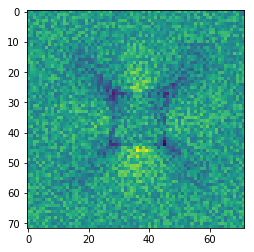

In [10]:
# Weights visualization for the model trained with Adam
colormap = "viridis"
model = models[1]
w = model.get_weights()
plt.imshow(np.reshape(w[0][:, 0], [IMAGE_SIZE, IMAGE_SIZE]), cmap=colormap)

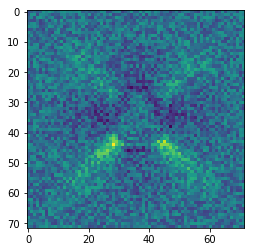

In [11]:
plt.imshow(np.reshape(w[0][:, 1], [IMAGE_SIZE, IMAGE_SIZE]), cmap=colormap)

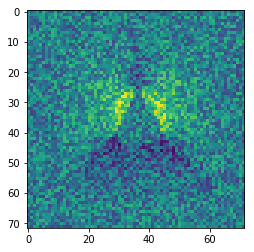

In [12]:
plt.imshow(np.reshape(w[0][:, 2], [IMAGE_SIZE, IMAGE_SIZE]), cmap=colormap)

# Comments #
Visualizing the weights is telling : the weights corresponding to the first output neuron, corresponding to the probability of the input image being a rectangle, shows rectangle shapes when displayed as an image. The same goes for the weights of the second output neuron (disk class) and of the third output neuron (triangle class).

# Question 5 #

In [13]:
# Creation of the training dataset, using images with free center and dimensions
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

# Encode labels into one-hot vectors
Y_train_categorical = np.array(list(map(int, Y_train)))
Y_train_categorical = to_categorical(Y_train_categorical, num_classes=3)

Creating data:


In [14]:
# Define, compile and train linear models (for 100 epochs) with either SGD or Adam as optimizers
optims = [optimizers.SGD(lr=0.001, decay=0.0, momentum=0.9, nesterov=True), optimizers.Adam(lr=0.001)]
models = []

for optim in optims:
    
    # Define model
    reg_coeff = 0.1 # L2 regularization coefficient
    model = Sequential([
        Dense(3, input_shape=(5184, ), kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('softmax'),
    ])
    
    # Compile model
    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train, Y_train_categorical, epochs=100, batch_size=32)
    
    # Add model to the model list
    models.append(model)

Epoch 1/100
300/300 [==============================] - 0s 863us/step - loss: 2.2659 - acc: 0.3300
Epoch 2/100
300/300 [==============================] - 0s 137us/step - loss: 1.7595 - acc: 0.4200
Epoch 3/100
300/300 [==============================] - 0s 147us/step - loss: 2.0063 - acc: 0.4533
Epoch 4/100
300/300 [==============================] - 0s 143us/step - loss: 1.8507 - acc: 0.4200
Epoch 5/100
300/300 [==============================] - 0s 147us/step - loss: 1.5754 - acc: 0.4933
Epoch 6/100
300/300 [==============================] - 0s 140us/step - loss: 1.5088 - acc: 0.5267
Epoch 7/100
300/300 [==============================] - 0s 143us/step - loss: 1.4318 - acc: 0.5800
Epoch 8/100
300/300 [==============================] - 0s 157us/step - loss: 1.3464 - acc: 0.5800
Epoch 9/100
300/300 [==============================] - 0s 133us/step - loss: 1.4214 - acc: 0.5433
Epoch 10/100
300/300 [==============================] - 0s 147us/step - loss: 1.7154 - acc: 0.4967
Epoch 11/100
300/30

300/300 [==============================] - 0s 130us/step - loss: 0.9174 - acc: 0.6933
Epoch 84/100
300/300 [==============================] - 0s 133us/step - loss: 0.8664 - acc: 0.6400
Epoch 85/100
300/300 [==============================] - 0s 133us/step - loss: 0.8096 - acc: 0.7033
Epoch 86/100
300/300 [==============================] - 0s 140us/step - loss: 0.9078 - acc: 0.6433
Epoch 87/100
300/300 [==============================] - 0s 147us/step - loss: 0.7624 - acc: 0.7500
Epoch 88/100
300/300 [==============================] - 0s 130us/step - loss: 0.8055 - acc: 0.7433
Epoch 89/100
300/300 [==============================] - 0s 143us/step - loss: 0.7224 - acc: 0.7867
Epoch 90/100
300/300 [==============================] - 0s 137us/step - loss: 0.8025 - acc: 0.6967
Epoch 91/100
300/300 [==============================] - 0s 137us/step - loss: 0.9005 - acc: 0.6533
Epoch 92/100
300/300 [==============================] - 0s 137us/step - loss: 0.7926 - acc: 0.7267
Epoch 93/100
300/300 [=

Epoch 66/100
300/300 [==============================] - 0s 140us/step - loss: 0.9082 - acc: 0.6967
Epoch 67/100
300/300 [==============================] - 0s 133us/step - loss: 1.0361 - acc: 0.5800
Epoch 68/100
300/300 [==============================] - 0s 140us/step - loss: 1.0063 - acc: 0.6133
Epoch 69/100
300/300 [==============================] - 0s 140us/step - loss: 1.0229 - acc: 0.6033
Epoch 70/100
300/300 [==============================] - 0s 140us/step - loss: 0.9503 - acc: 0.6633
Epoch 71/100
300/300 [==============================] - 0s 140us/step - loss: 0.8644 - acc: 0.6733
Epoch 72/100
300/300 [==============================] - 0s 140us/step - loss: 0.8290 - acc: 0.7533
Epoch 73/100
300/300 [==============================] - 0s 147us/step - loss: 0.8213 - acc: 0.7300
Epoch 74/100
300/300 [==============================] - 0s 140us/step - loss: 0.7936 - acc: 0.7867
Epoch 75/100
300/300 [==============================] - 0s 137us/step - loss: 0.8090 - acc: 0.7467
Epoch 76/1

In [15]:
# Generation of the test dataset, using images with free center and dimensions
[X_test, Y_test] = generate_test_set_classification()
print("Test dataset created")

# Labels proportions
proportions = [0, 0, 0]
for y in Y_test:
    i = np.argmax(y)
    proportions[i] += 1
proportions = np.array(proportions) / 300
print("Proportions : ", proportions)

Creating data:
Test dataset created
Proportions :  [0.34666667 0.36333333 0.29      ]


In [16]:
# Model evaluation for both SGD and Adam

for i, m in enumerate(["SGD", "Adam"]):
    print("\nOptimizer used : ", m)
    model = models[i]
    score = model.evaluate(X_test, Y_test, batch_size=128)
    print("Loss : ", score[0])
    print("Accuracy : ", score[1])


Optimizer used :  SGD
300/300 [==============================] - 0s 303us/step
Loss :  1.838888128598531
Accuracy :  0.44333333333333336

Optimizer used :  Adam
300/300 [==============================] - 0s 266us/step
Loss :  1.906844557126363
Accuracy :  0.47999999682108563


# Comments #

Now that the images in the training and test dataset have free locations and dimentions, I trained the linear model again, for 100 epochs, using either SGD with fixed learning rate or Adam, and with L2 regularization.
I could not reach more than 28% accuracy on the test set.<br>

Compared to the previous situation, the task is now more difficult, and thus a linear model does not perform very well.

In [17]:
# Creation of the training dataset, using images with free center and dimensions
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)

# Encode labels into one-hot vectors
Y_train_categorical = np.array(list(map(int, Y_train)))
Y_train_categorical = to_categorical(Y_train_categorical, num_classes=3)

# Reshape the training dataset into 2D images
X_train_reshaped = np.reshape(X_train, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

Creating data:


In [18]:
# Define, compile and train a CNN (for 200 epochs) with Adam as optimizer
#optims = [optimizers.SGD(lr=0.001, decay=0.0, momentum=0.9, nesterov=True), optimizers.Adam(lr=0.001)]
optims = [optimizers.Adam(lr=0.005)]
models = []

for optim in optims:
    
    # Define model
    reg_coeff = 0.01 # L2 regularization coefficient
    nb_filters = 16
    kernel_size=(5, 5)
    s = (1, 1)
    model = Sequential([
        Conv2D(nb_filters, kernel_size, input_shape=(72, 72, 1), strides=s, padding='valid', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('relu'),
        MaxPooling2D(pool_size=(4, 4), padding='valid'),
        Flatten(),
        Dense(3, kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('softmax'),
    ])
    
    # Compile model
    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train_reshaped, Y_train_categorical, epochs=200, batch_size=32)
    
    # Add model to the model list
    models.append(model)

Epoch 1/200
1000/1000 [==============================] - 4s 4ms/step - loss: 1.1619 - acc: 0.5350
Epoch 2/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8806 - acc: 0.7030
Epoch 3/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7905 - acc: 0.7470
Epoch 4/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7420 - acc: 0.7690
Epoch 5/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6981 - acc: 0.7860
Epoch 6/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6652 - acc: 0.8210
Epoch 7/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6596 - acc: 0.8110
Epoch 8/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5935 - acc: 0.8640
Epoch 9/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5645 - acc: 0.8920
Epoch 10/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5409 - acc: 0.8980
Epoch 11/200
1000/1

1000/1000 [==============================] - 4s 4ms/step - loss: 0.3843 - acc: 0.9630
Epoch 84/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3685 - acc: 0.9680
Epoch 85/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3899 - acc: 0.9500
Epoch 86/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4102 - acc: 0.9530
Epoch 87/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3857 - acc: 0.9660
Epoch 88/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3879 - acc: 0.9660
Epoch 89/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3794 - acc: 0.9610
Epoch 90/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4213 - acc: 0.9450
Epoch 91/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3848 - acc: 0.9620
Epoch 92/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3739 - acc: 0.9650
Epoch 93/200
1000/1000 

1000/1000 [==============================] - 3s 3ms/step - loss: 0.3730 - acc: 0.9690
Epoch 166/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3551 - acc: 0.9600
Epoch 167/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3549 - acc: 0.9650
Epoch 168/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3628 - acc: 0.9720
Epoch 169/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3463 - acc: 0.9710
Epoch 170/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3620 - acc: 0.9660
Epoch 171/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3505 - acc: 0.9760
Epoch 172/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3539 - acc: 0.9720
Epoch 173/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3465 - acc: 0.9650
Epoch 174/200
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3523 - acc: 0.9690
Epoch 175/200


In [19]:
# Generation of the test dataset, using images with free center and dimensions
[X_test, Y_test] = generate_test_set_classification(free_location=True)
print("Test dataset created")

# Reshape the test dataset into 2D images
X_test_reshaped = np.reshape(X_test, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

# Labels proportions
proportions = [0, 0, 0]
for y in Y_test:
    i = np.argmax(y)
    proportions[i] += 1
proportions = np.array(proportions) / 300
print("Proportions : ", proportions)

Creating data:
Test dataset created
Proportions :  [0.34 0.33 0.33]


In [20]:
# Model evaluation for Adam

for i, m in enumerate(["Adam"]):
    print("\nOptimizer used : ", m)
    model = models[i]
    score = model.evaluate(X_test_reshaped, Y_test, batch_size=128)
    print("Loss : ", score[0])
    print("Accuracy : ", score[1])


Optimizer used :  Adam
300/300 [==============================] - 1s 2ms/step
Loss :  0.442264518737793
Accuracy :  0.9266666706403096


# Comments #

I trained an architecture close to the suggested one : one convolutional layer of 16 5x5 filters, with ReLU activation, followed by a 4x4 max pooling and a final fully connected layer.
Training on 1000 examples for 200 epochs, I was able to get up to 93% accuracy on the test set.

# Question 6 #

Creating data:
Training set created
Creating data:
Test set created


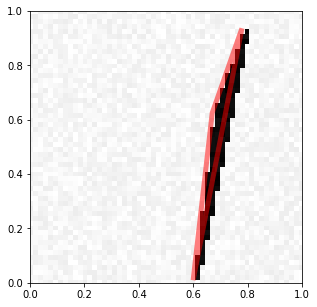

In [216]:
# Creation of the training set
[X_train, Y_train] = generate_dataset_regression(300, 20)
print("Training set created")

# Creation of the test set
[X_test, Y_test] = generate_test_set_regression()
print("Test set created")

# Visualization of the training set
visualize_prediction(X_train[0], Y_train[0])

# Reshape the training and test dataset into 2D images
X_train_reshaped = np.reshape(X_train, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
X_test_reshaped = np.reshape(X_test, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

In [222]:
# Convert images into their gradient, as it allows to convert the full triangles into their edges, thus removing information
# but keeping the vertices

X_train_gradient = np.zeros([len(X_train), IMAGE_SIZE, IMAGE_SIZE])
for i in range(len(X_train_reshaped)):
    im = np.reshape(X_train_reshaped[i], [IMAGE_SIZE, IMAGE_SIZE])
    sx = ndimage.sobel(im, axis=0, mode='constant')
    sy = ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    X_train_gradient[i] = sob

X_train_gradient = np.reshape(X_train_gradient, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

X_test_gradient = np.zeros([len(X_test), IMAGE_SIZE, IMAGE_SIZE])
for i in range(len(X_test_reshaped)):
    im = np.reshape(X_test_reshaped[i], [IMAGE_SIZE, IMAGE_SIZE])
    sx = ndimage.sobel(im, axis=0, mode='constant')
    sy = ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    X_test_gradient[i] = sob

X_test_gradient = np.reshape(X_test_gradient, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

In [234]:
# Convert the train "labels" into their "one-hot" version (the image with only the 3 vertices)

Y_train_one_hot = np.zeros([len(Y_train), IMAGE_SIZE, IMAGE_SIZE])

for i, y in enumerate(Y_train):
    z = np.floor(y * IMAGE_SIZE)
    z = np.array([int(u) for u in z])
    for j in range(3):
        Y_train_one_hot[i][z[2 * j], z[2 * j + 1]] = 1

Y_train_one_hot_1d = np.reshape(Y_train_one_hot, [len(Y_train), 5184]) / 3
Y_train_one_hot_2d = np.reshape(Y_train_one_hot, [len(Y_train), IMAGE_SIZE, IMAGE_SIZE, 1])

In [235]:
# Define, compile and train a CNN (for __ epochs) with Adam as optimizer
#optims = [optimizers.SGD(lr=0.001, decay=0.0, momentum=0.9, nesterov=True), optimizers.Adam(lr=0.001)]
optims = [optimizers.Adam(lr=0.01)]
models = []

for optim in optims:
    
    # Define model
    reg_coeff = 0 # L2 regularization coefficient
    model = Sequential([
        Conv2D(16, (5, 5), input_shape=(72, 72, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), padding='valid'),
        Conv2D(32, (3, 3), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), padding='valid'),
        Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), padding='valid'),
        Flatten(),
        Dense(5184),
        Activation('softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy'
    )

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train_gradient, Y_train_one_hot_1d, epochs=100, batch_size=32)
    
    # Add model to the model list
    models.append(model)

Epoch 1/100
300/300 [==============================] - 8s 28ms/step - loss: 8.5996
Epoch 2/100
300/300 [==============================] - 6s 19ms/step - loss: 7.9170
Epoch 3/100
300/300 [==============================] - 6s 20ms/step - loss: 7.0230
Epoch 4/100
300/300 [==============================] - 5s 18ms/step - loss: 5.7248
Epoch 5/100
300/300 [==============================] - 6s 18ms/step - loss: 3.6161
Epoch 6/100
300/300 [==============================] - 6s 20ms/step - loss: 2.4564
Epoch 7/100
300/300 [==============================] - 5s 18ms/step - loss: 1.9307
Epoch 8/100
300/300 [==============================] - 5s 18ms/step - loss: 1.8026
Epoch 9/100
300/300 [==============================] - 6s 19ms/step - loss: 1.9147
Epoch 10/100
300/300 [==============================] - 5s 18ms/step - loss: 1.6253
Epoch 11/100
300/300 [==============================] - 5s 18ms/step - loss: 1.5134
Epoch 12/100
300/300 [==============================] - 6s 19ms/step - loss: 1.4220
E

300/300 [==============================] - 6s 21ms/step - loss: 1.1353
Epoch 99/100
300/300 [==============================] - 6s 18ms/step - loss: 1.1331
Epoch 100/100
300/300 [==============================] - 6s 19ms/step - loss: 1.1438


In [240]:
model = models[0]
idx_sample = 10
sample = np.reshape(X_test_gradient[idx_sample], [1, 72, 72, 1])
#sample = np.reshape(X_test_reshaped[idx_sample], [1, 72, 72, 1])
pred = np.reshape(model.predict(sample), [-1])

(72, 72, 1)
(5184,)


[0.97222222 0.51388889 0.16666667 0.73611111 0.88888889 0.30555556]


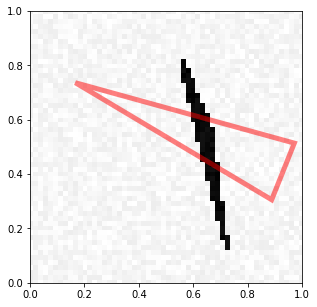

In [241]:
arr = pred.argsort()[-3:][::-1]
pred2 = []
for x in arr:
    i = np.floor(x / 72)
    j = x - 72 * i
    pred2.append(i)
    pred2.append(j)
    
pred2 = np.array(pred2) / 72
print(pred2)

visualize_prediction(X_train[idx_sample], pred2)

2nd method

In [256]:
# Define, compile and train a CNN (for __ epochs) with Adam as optimizer
#optims = [optimizers.SGD(lr=0.001, decay=0.0, momentum=0.9, nesterov=True), optimizers.Adam(lr=0.001)]
optims = [optimizers.Adam(lr=0.01)]
models = []

for optim in optims:
    
    # Define model
    reg_coeff = 0 # L2 regularization coefficient
    model = Sequential([
        Conv2D(36, (5, 5), input_shape=(72, 72, 1), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('sigmoid'),
        Conv2D(1, (1, 1), strides=(1, 1), padding='same'),
        Activation('sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=optim,
        loss='mean_squared_error'
    )

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train_reshaped, Y_train_one_hot_2d, epochs=20, batch_size=32)
    
    # Add model to the model list
    models.append(model)

Epoch 1/20
300/300 [==============================] - 3s 10ms/step - loss: 0.0894
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0018A: 0s - loss: 0
Epoch 3/20
300/300 [==============================] - 2s 7ms/step - loss: 9.3446e-04
Epoch 4/20
300/300 [==============================] - 2s 7ms/step - loss: 7.9948e-04
Epoch 5/20
300/300 [==============================] - 2s 7ms/step - loss: 7.5867e-04
Epoch 6/20
300/300 [==============================] - 2s 7ms/step - loss: 7.4174e-04
Epoch 7/20
300/300 [==============================] - 2s 7ms/step - loss: 7.3271e-04
Epoch 8/20
300/300 [==============================] - 2s 7ms/step - loss: 7.2639e-04
Epoch 9/20
300/300 [==============================] - 2s 6ms/step - loss: 7.2102e-04
Epoch 10/20
300/300 [==============================] - 2s 6ms/step - loss: 7.1628e-04
Epoch 11/20
300/300 [==============================] - 2s 7ms/step - loss: 7.1147e-04
Epoch 12/20
300/300 [==============================] - 

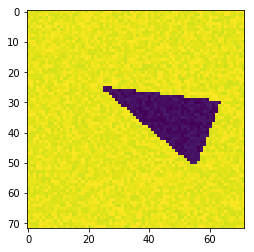

In [257]:
model = models[0]
idx_sample = 10
sample = np.reshape(X_test[idx_sample], [1, 72, 72, 1])
pred = np.reshape(model.predict(sample), [IMAGE_SIZE, IMAGE_SIZE])
plt.imshow(np.reshape(X_test[idx_sample], [IMAGE_SIZE, IMAGE_SIZE]))

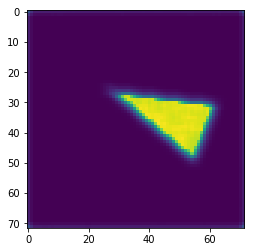

In [258]:
plt.imshow(pred)

# Comments #

I was not able to train a network to detect the vertices of a triangle in an image.

# Question 7 #

In [261]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_denoising(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noisy = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata_noisy

def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_denoising(figsize, U, V, noise)


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_denoising(figsize, U, V, noise)

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata, imdata_noisy = generate_a_drawing_denoising(figsize, U, V, noise)
    return [imdata, imdata_noisy, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noisy = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], X_noisy[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X[i], X_noisy[i] = generate_a_disk_denoising(noise, free_location)
        else:
            [X[i], X_noisy[i], V] = generate_a_triangle_denoising(noise, free_location)
        Y[i] = category
    #X = (X + noise) / (255 + 2 * noise)
    return [X, X_noisy, Y]

def generate_test_set_classification_denoising(free_location=False):
    np.random.seed(42)
    [X_test, X_noisy_test, Y_test] = generate_dataset_classification_denoising(300, 20, free_location)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, X_noisy_test, Y_test]


In [270]:
# Generation of the datasets
[X_train, X_train_noisy, Y_train] = generate_dataset_classification_denoising(300, 20, free_location=True)
print("Train dataset created")
[X_test, X_test_noisy, Y_test] = generate_test_set_classification_denoising(free_location=True)
print("Test dataset created")

# Reshape the datasets into 2D images
X_train_reshaped = np.reshape(X_train, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
X_train_noisy_reshaped = np.reshape(X_train_noisy, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
X_test_reshaped = np.reshape(X_test, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
X_test_noisy_reshaped = np.reshape(X_test_noisy, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

Creating data:
Train dataset created
Creating data:
Test dataset created


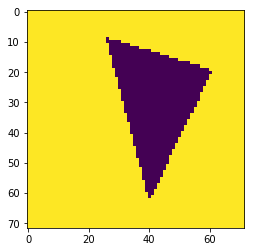

In [271]:
plt.imshow(np.reshape(X_train[0], [IMAGE_SIZE, IMAGE_SIZE]))

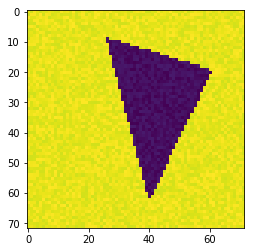

In [272]:
plt.imshow(np.reshape(X_train_noisy[0], [IMAGE_SIZE, IMAGE_SIZE]))

In [274]:
# Define, compile and train a CNN (for __ epochs) with Adam as optimizer
#optims = [optimizers.SGD(lr=0.001, decay=0.0, momentum=0.9, nesterov=True), optimizers.Adam(lr=0.001)]
optims = [optimizers.Adam(lr=0.01)]
models = []

for optim in optims:
    
    # Define model
    reg_coeff = 0.01 # L2 regularization coefficient
    model = Sequential([
        Conv2D(16, (5, 5), input_shape=(72, 72, 1), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('relu'),
        Conv2D(1, (5, 5), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(reg_coeff)),
        Activation('relu')
    ])
    
    # Compile model
    model.compile(
        optimizer=optim,
        loss='mean_squared_error'
    )

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train_noisy_reshaped, X_train_reshaped, epochs=100, batch_size=32)
    
    # Add model to the model list
    models.append(model)

Epoch 1/100
300/300 [==============================] - 7s 22ms/step - loss: 22958.1569
Epoch 2/100
300/300 [==============================] - 5s 18ms/step - loss: 4128.5488
Epoch 3/100
300/300 [==============================] - 6s 19ms/step - loss: 2736.0663
Epoch 4/100
300/300 [==============================] - 5s 17ms/step - loss: 2052.2809
Epoch 5/100
300/300 [==============================] - 5s 16ms/step - loss: 1328.7594
Epoch 6/100
300/300 [==============================] - 5s 18ms/step - loss: 915.1852
Epoch 7/100
300/300 [==============================] - 5s 17ms/step - loss: 647.7574
Epoch 8/100
300/300 [==============================] - 5s 18ms/step - loss: 493.1293
Epoch 9/100
300/300 [==============================] - 5s 18ms/step - loss: 392.2668
Epoch 10/100
300/300 [==============================] - 5s 16ms/step - loss: 315.4953
Epoch 11/100
300/300 [==============================] - 5s 18ms/step - loss: 234.7950
Epoch 12/100
300/300 [==============================] - 5

300/300 [==============================] - 7s 22ms/step - loss: 38.8913
Epoch 98/100
300/300 [==============================] - 7s 23ms/step - loss: 24.9226
Epoch 99/100
300/300 [==============================] - 6s 21ms/step - loss: 18.7632
Epoch 100/100
300/300 [==============================] - 6s 19ms/step - loss: 17.0827


In [278]:
model = models[0]
idx_sample = 100
sample = np.reshape(X_test_noisy[idx_sample], [1, 72, 72, 1])
pred = np.reshape(model.predict(sample), [IMAGE_SIZE, IMAGE_SIZE])

Original image :


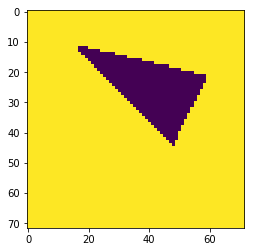

In [281]:
print("Original image :")
plt.imshow(np.reshape(X_test[idx_sample], [IMAGE_SIZE, IMAGE_SIZE]))

Original noisy image :


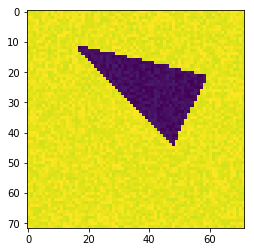

In [282]:
print("Original noisy image :")
plt.imshow(np.reshape(X_test_noisy[idx_sample], [IMAGE_SIZE, IMAGE_SIZE]))

Denoised image :


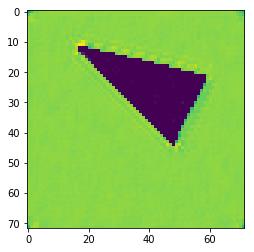

In [283]:
print("Denoised image :")
plt.imshow(pred)

# Comments #

We can see that the images are denoised, but at the cost of blurrier edges.